### Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

### Model Input

[*********************100%***********************]  1 of 1 completed


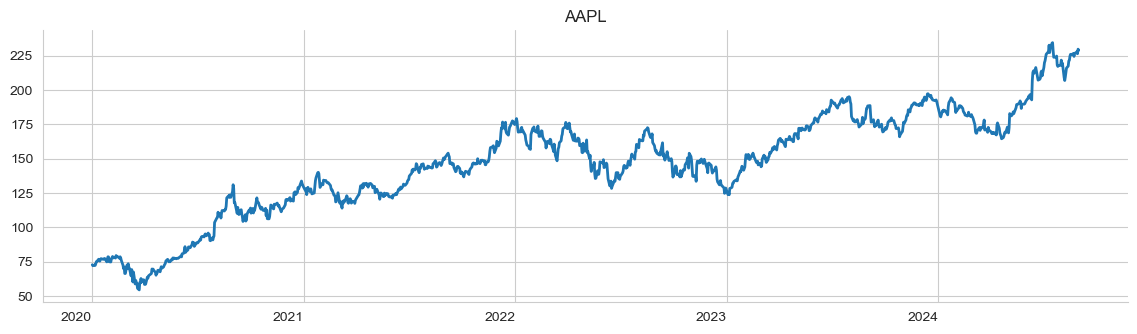

In [9]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'AAPL'

# Download stock data from yahoo finance
stocks = yf.download('AAPL',start_date ,end_date)
price_type = 'Adj Close'
stock_price = pd.DataFrame(stocks[price_type])
# print(stock_price)

ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [11]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(), 
                         index = stock_price.index)
# print(stocks_scaled)

### Model Processing

In [14]:
def create_univariate_lstm_data(data, window_size):
    n = len(data) 
    y = data[window_size:]
    # print(data)
    data = data.values.reshape(-1, 1) # make 2D
    # print(data)
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = create_univariate_lstm_data(stocks_scaled, window_size = window_size)

# Train-test split
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
# print(X_train)
y_train = y[:'2022']
y_train.shape

n_obs, window_size, n_features = X_train.shape 
# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
# print(X_test)
y_test = y['2023':]

In [16]:
X_train.shape

(696, 60, 1)

In [18]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(LSTM(hidden_units, input_shape = input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create model and train
lstm = create_LSTM(hidden_units = 50, dense_units = 1, input_shape = (window_size, n_features), 
                   activation=['tanh', 'linear'])
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
LSTM_training = lstm.fit(X_train, 
                       y_train, 
                       epochs = 128, 
                       batch_size = 20,
                       validation_data = (X_test, y_test),
                       verbose=1)

Epoch 1/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0629 - val_loss: 0.0085
Epoch 2/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.3112e-04 - val_loss: 0.0016
Epoch 5/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.2771e-04 - val_loss: 8.5345e-04
Epoch 6/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.1004e-04 - val_loss: 8.5665e-04
Epoch 7/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.5591e-04 - val_loss: 7.8765e-04
Epoch 8/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.3146e-04 - val_loss: 0.0010
Epoch 9/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.6931e-04 - val_loss: 7.5496e-04
Epoch 10/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.8261e-04 - val_loss: 8.7730e-04
Epoch 11/128
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.0440e-04 - val_loss: 8.5819e

### Model Output

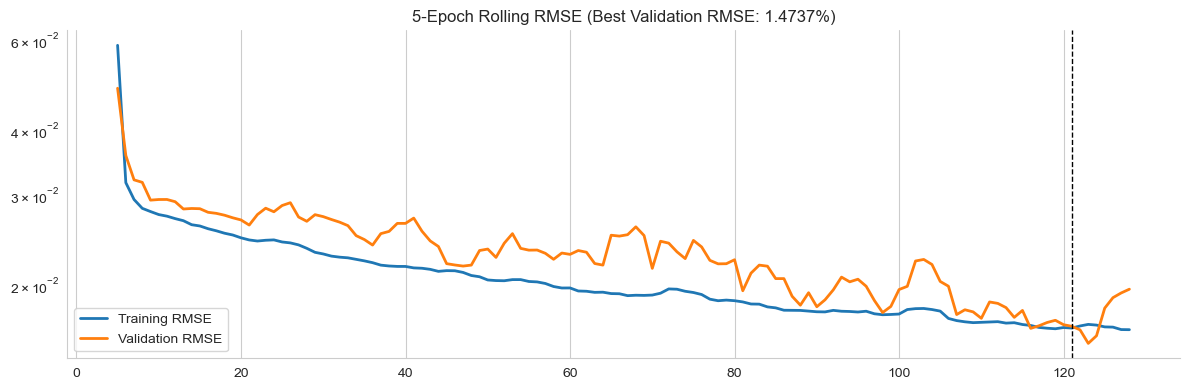

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(LSTM_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [58]:
train_rmse_scaled = np.sqrt(lstm.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0302 | Test RMSE (scaled): 0.0268


In [61]:
train_predict_scaled = lstm.predict(X_train)
test_predict_scaled = lstm.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train IC: 0.9823 | Test IC: 0.9926


**Rescale Predictions**

In [64]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [66]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 3.57 | Test RMSE: 3.16


In [68]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), 
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on = 'Date')
# remove the suffixes brought by pd.merge()
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

### Visualization

In [71]:
stock_price

,Adj Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-03-30,98.197502,94.984619,NaN,94.984619,Train
2020-03-31,97.486000,96.712341,NaN,96.712341,Train
2020-04-01,95.385002,96.934547,NaN,96.934547,Train
2020-04-02,95.941498,95.462410,NaN,95.462410,Train
2020-04-03,95.329498,95.299973,NaN,95.299973,Train
...,...,...,...,...,...
2024-08-26,175.500000,NaN,174.895081,174.895081,Test
2024-08-27,173.119995,NaN,173.970367,173.970367,Test
2024-08-28,170.800003,NaN,171.558456,171.558456,Test


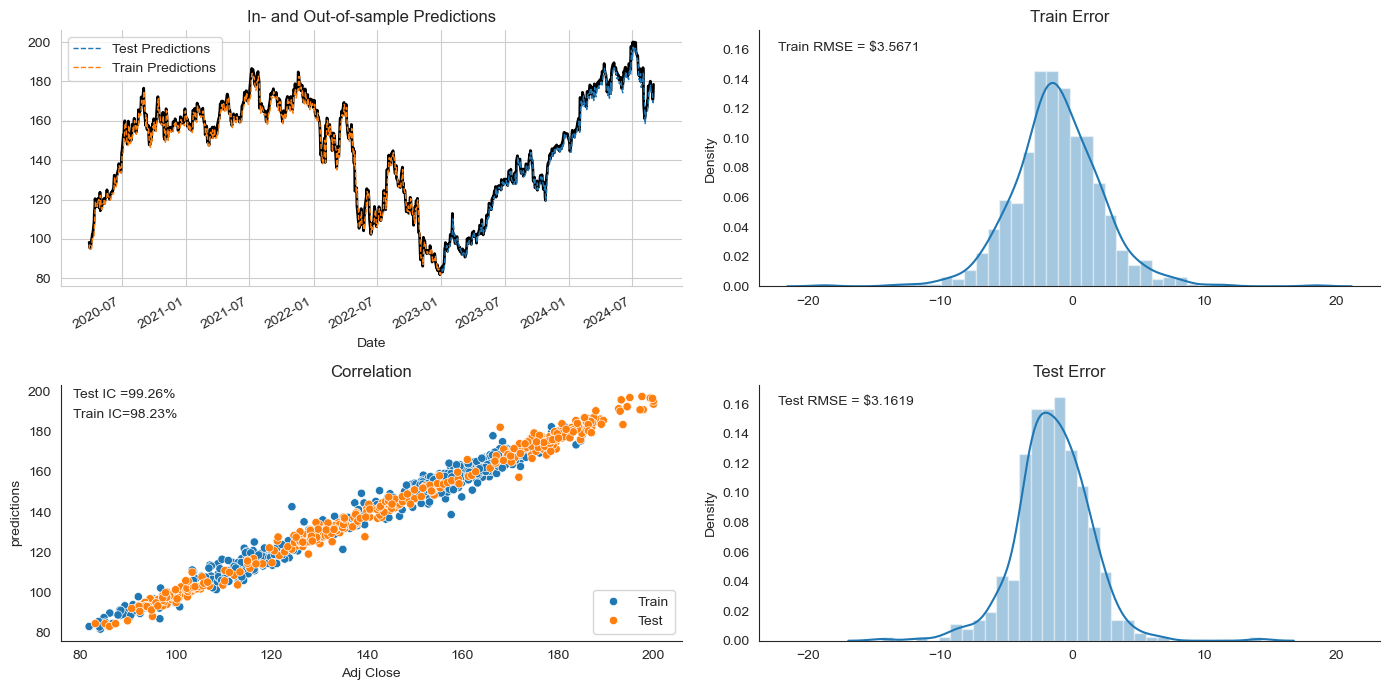

In [73]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2020':, price_type].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2020':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x = price_type, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()

**Changes made in the Hyperparamter**

###### hidden_units = 50
###### activation=['tanh', 'linear']
###### epochs = 100
###### batch_size = 20
###### window_size = 60